In [102]:
import astropy.units as u
from astropy.time import Time
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import tqdm
import string
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import time_support
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import pandas as pd

In [103]:
targets = {
    'HAT-P-11': 1, 
    'K2-121': 1,
    'K2-136': 3,
    'WASP-43': 1,
    'WASP-107': 1,
    'GJ 9827': 3,
    'K2-266': 4,
    'K2-3': 3,
    'Kepler-138': 3,
    'AU Mic': 1,
    'GJ 357': 1,
    'GJ 3470': 1,
    'K2-18': 1,
    'GJ 436': 1,
    'L 98-59': 3,
    'K2-33':1 ,
    'LTT 1445 A': 1,
    'K2-25': 1,
    'LHS 3844': 1,
    'TRAPPIST 1': 7,
}
transit_times = {}
anti_solar = {}

In [148]:
for star in tqdm.tqdm(targets):
    for pletter in string.ascii_lowercase[1:targets[star]+1]:
        planet_properties = NasaExoplanetArchive.query_planet(f"{star} {pletter}", all_columns=True)

        # get relevant planet properties
        epoch = Time(planet_properties['pl_tranmid'], format='jd')
        period = planet_properties['pl_orbper']
        transit_duration = planet_properties['pl_trandur'] 

        # Create an EclipsingSystem object for HD 209458
        from astroplan import EclipsingSystem
        planet = EclipsingSystem(primary_eclipse_time=epoch, orbital_period=period,
                                     duration=transit_duration)

        # Calculate next three mid-transit times which occur after ``obs_time``
        obs_time = Time('2025-01-01 00:00')
        n_eclipses = 365.25 * u.day / period + 1
        planet.next_primary_eclipse_time(obs_time, n_eclipses=n_eclipses)

        transit_times[f"{star} {pletter}"] =  planet.next_primary_eclipse_time(obs_time, n_eclipses=n_eclipses)
        
        ast = ((Time('2025-03-21 00:00') +
                   (planet_properties["st_elon"] /(360*u.deg)) *
                   365.25 * u.day) - (3*365.25) * u.day)
        while ast < Time('2025-1-1 00:00'):
                ast += 365.25 * u.day
        anti_solar[f"{star} {pletter}"] = ast

  0%|          | 0/20 [00:00<?, ?it/s]WARNING: AstropyDeprecationWarning: The query_planet function is deprecated and may be removed in a future version.
        Use query_object instead. [warnings]
100%|██████████| 20/20 [02:17<00:00,  6.87s/it]


In [149]:

# march 21 is approximately ecliptic longitude zero at antisolar
# so let's check for when a planet is +/- 30 ecliptic long of antisolar


In [150]:
anti_solar

{'HAT-P-11 b': <Time object: scale='utc' format='iso' value=['2025-02-09 23:41:39.258']>,
 'K2-121 b': <Time object: scale='utc' format='iso' value=['2025-07-25 18:52:28.097']>,
 'K2-136 b': <Time object: scale='utc' format='iso' value=['2025-05-30 06:46:48.766']>,
 'K2-136 c': <Time object: scale='utc' format='iso' value=['2025-05-30 06:46:48.766']>,
 'K2-136 d': <Time object: scale='utc' format='iso' value=['2025-05-30 06:46:48.766']>,
 'WASP-43 b': <Time object: scale='utc' format='iso' value=['2025-08-30 20:41:41.103']>,
 'WASP-107 b': <Time object: scale='utc' format='iso' value=['2025-10-01 12:04:18.236']>,
 'GJ 9827 b': <Time object: scale='utc' format='iso' value=['2025-03-12 19:34:55.081']>,
 'GJ 9827 c': <Time object: scale='utc' format='iso' value=['2025-03-12 19:34:55.081']>,
 'GJ 9827 d': <Time object: scale='utc' format='iso' value=['2025-03-12 19:34:55.081']>,
 'K2-266 b': <Time object: scale='utc' format='iso' value=['2025-08-29 13:40:44.441']>,
 'K2-266 c': <Time objec

In [156]:
ttime >= anti_solar[tt] - 39

array([ True])

100%|██████████| 39/39 [00:08<00:00,  4.57it/s]


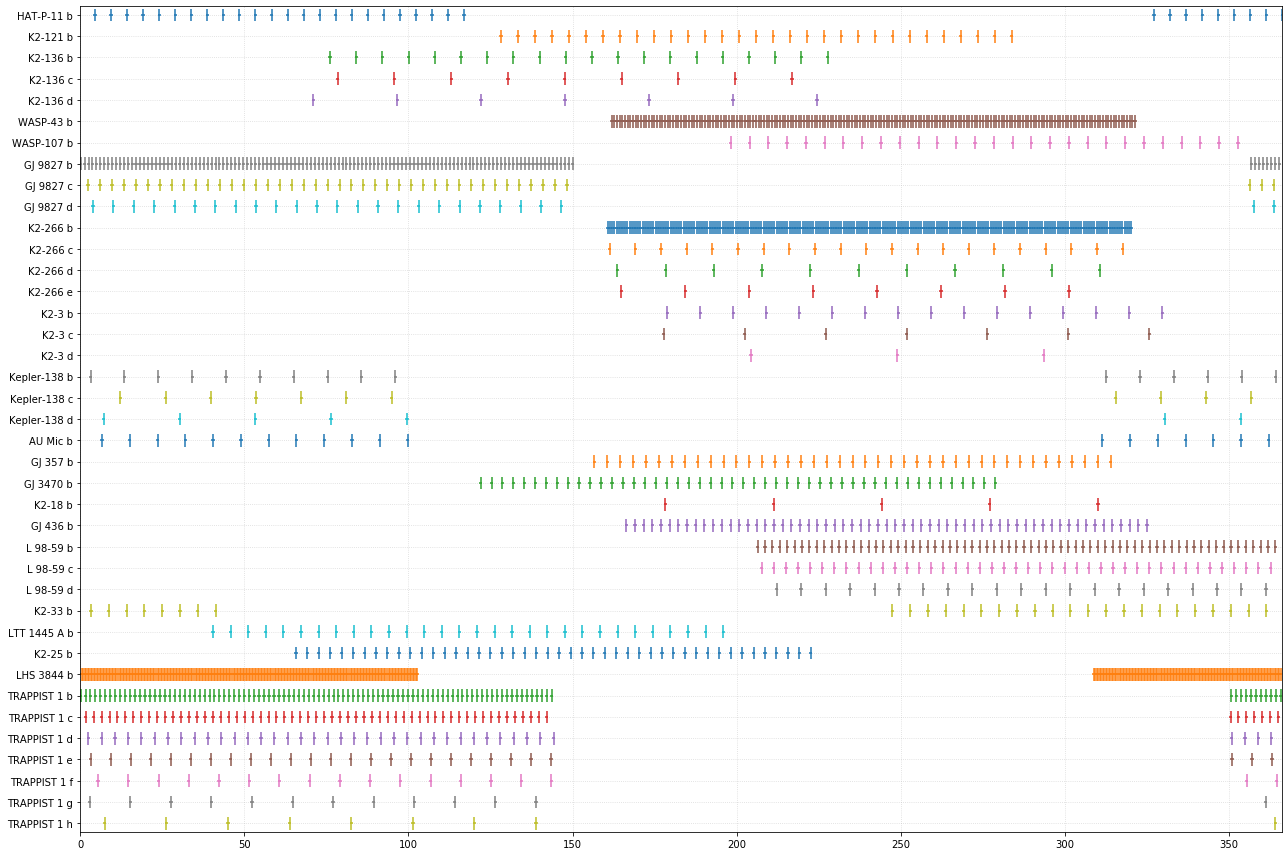

In [178]:
i = len(transit_times)-1
window = 80
# with time_support():
yticklabels = []
fig, ax = plt.subplots(1, 1, figsize=[18, 12])
for tt in tqdm.tqdm(transit_times):
    ntransits = len(transit_times[tt])
    mask = np.ones(ntransits, dtype=bool)
    for j, ttime in enumerate(transit_times[tt]):
        if (((ttime >= anti_solar[tt] - window) and (ttime <= anti_solar[tt] + window)) or
            ((ttime >= anti_solar[tt] - window - 365.25) and (ttime <= anti_solar[tt] + window - 365.25)) or 
            ((ttime >= anti_solar[tt] - window + 365.25) and (ttime <= anti_solar[tt] + window + 365.25))):
            mask[j] = True
        else:
            mask[j] = False
    tx = (transit_times[tt][mask] - Time('2025-01-01 00:00')).jd
    ax.errorbar(tx, np.repeat(i, len(tx)), xerr=0.5,
            yerr=0.3,
            ls="",
            marker="")
    yticklabels.append(tt)
    i -= 1
ax.set(yticks=np.arange(len(transit_times)), yticklabels=yticklabels[::-1])
ax.set_xlim(0, 366)
ax.grid(ls=":", alpha=0.5)
# ax.set_xlim(0, 60)
ax.set_ylim(-0.4, len(transit_times)-1+0.4)

plt.tight_layout()

plt.savefig("mock_observing calendar.png", dpi=200)

In [167]:
(transit_times[tt][mask] - Time('2025-01-01 00:00')).jd

array([14.32095316, 19.2087556 , 24.09655804, 28.98436048, 33.87216292,
       38.75996536, 43.6477678 , 48.53557024, 53.42337268, 58.31117512,
       63.19897756, 68.08678   ])

In [62]:
transit_times[tt].jd - Time('2025-01-01 00:00').jd

array([  4.54534828,   9.43315072,  14.32095316,  19.2087556 ,
        24.09655804,  28.98436048,  33.87216292,  38.75996536,
        43.6477678 ,  48.53557024,  53.42337268,  58.31117512,
        63.19897756,  68.08678   ,  72.97458244,  77.86238488,
        82.75018732,  87.63798976,  92.5257922 ,  97.41359464,
       102.30139708, 107.18919952, 112.07700196, 116.9648044 ,
       121.85260684, 126.74040928, 131.62821172, 136.51601416,
       141.4038166 , 146.29161904, 151.17942148, 156.06722392,
       160.95502636, 165.8428288 , 170.73063124, 175.61843368,
       180.50623612, 185.39403856, 190.281841  , 195.16964344,
       200.05744588, 204.94524832, 209.83305076, 214.7208532 ,
       219.60865564, 224.49645808, 229.38426052, 234.27206296,
       239.1598654 , 244.04766784, 248.93547028, 253.82327272,
       258.71107516, 263.5988776 , 268.48668004, 273.37448248,
       278.26228492, 283.15008736, 288.0378898 , 292.92569224,
       297.81349468, 302.70129712, 307.58909956, 312.47

In [182]:
90 - np.degrees(np.arctan(18/45))

68.19859051364818